The used data comes from Kaggle dataset https://www.kaggle.com/datasets/paultimothymooney/stock-market-data. I used only data from nasdaq/csv folder.

In [21]:
import datetime
import os
from os import listdir
from os.path import join
import pathlib
from typing import Tuple
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Softmax
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from time import time
from keras import mixed_precision
from joblib import Parallel, delayed
from keras.utils import to_categorical
import functools

In [24]:
START_DATE = "1999-12-31"
TRAIN_END = "2019-01-01"
VAL_END = "2021-01-01"
FEATURES = ["Low", "Open", "High", "Close", "Volume", "Adjusted Close"]
TARGET_FEATURE = "Adjusted Close"
TARGET = "Target"
WINDOW = 30
SANITY_CHECK = False
PCT_THRESHOLD = 0.005  # "1" is 100%
INCREASE = 0
CONST = 1
DECREASE = 2
NO_OF_CLASSES = 3

In [19]:
def load_csv(csv_path: str, date_format="%Y-%m-%d") -> pd.DataFrame:
    df = pd.read_csv(csv_path, index_col="Date")
    df.index = pd.to_datetime(df.index, format=date_format)
    return df


def map_pct_change_to_label(x: float):
    if abs(x) < PCT_THRESHOLD:
        return CONST
    elif x >= PCT_THRESHOLD:
        return INCREASE
    elif x <= PCT_THRESHOLD:
        return DECREASE
    raise Exception("Cannot map value to class INCREASE, CONST, DECREASE")


def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df[START_DATE:]
    volume = pd.Series(np.log(df["Volume"] + 1)).diff(1)[1:]
    df = df.pct_change(1)[1:]
    df["Volume"] = volume
    target = df[TARGET_FEATURE].map(map_pct_change_to_label).astype(int)
    scaler = StandardScaler()
    scaler = scaler.fit(df[:TRAIN_END][FEATURES].values)
    scaled_x = scaler.transform(df[FEATURES].values)
    df = pd.DataFrame(scaled_x, index=df.index, columns=df.columns)
    date_index = df.index.to_series()
    df["Weekday"] = (date_index.dt.day_of_week / 2) - 1
    df["Month Sin"] = np.sin(date_index.dt.month * (2 * np.pi / 12))
    df["Month Cos"] = np.cos(date_index.dt.month * (2 * np.pi / 12))
    df[TARGET] = target
    return df


def is_valid_csv(csv_path: str, df: pd.DataFrame) -> bool:
    min_len = WINDOW + 1
    if df.isnull().values.any():
        print(f"Skipping {csv_path}, nans detected")
        return False

    if len(df[START_DATE:]) < min_len:
        print(f"Skipping {csv_path}, not enough data at all")
        return False

    if len(df[START_DATE:TRAIN_END]) < min_len:
        print(f"Skipping {csv_path}, not enough train data")
        return False

    if len(df[TRAIN_END:VAL_END]) < min_len:
        print(f"Skipping {csv_path}, not enough val data")
        return False

    if len(df[VAL_END:]) < min_len:
        print(f"Skipping {csv_path}, not enough test data")
        return False

    return True


def process(idx: int, csv_path: str):
    print(f"Progress {csv_path} {idx}/1563", flush=True)
    df = load_csv(csv_path, date_format="%d-%m-%Y")
    if is_valid_csv(csv_path, df):
        df = preprocess(df)
        df.to_csv(f"data/preprocessed/{os.path.basename(csv_path)}")
        return df[TARGET].value_counts()


Build preprocessed csv files

In [22]:
dataset_path = "data\csv"
csv_paths = [join(dataset_path, f) for f in listdir(dataset_path)]
distributions = Parallel(n_jobs=-1)(delayed(process)(idx, csv_path) for idx, csv_path in enumerate(csv_paths))

distributions = list(filter(lambda x: x is not None, distributions))
distribution = functools.reduce(lambda x,y: x+y, distributions, pd.Series([0,0,0], index=[0,1,2]) )
distribution = (distribution / distribution.sum()) * 100
distribution = distribution.rename(index = {INCREASE: "INCREASE", CONST: "CONST", DECREASE: "DECREASE"})
print(distribution)

INCREASE    36.548176
CONST       26.814006
DECREASE    36.637818
dtype: float64


Create datasets TRAIN, VAl, TEST

In [9]:
def make_generator(start, end):
    def generator():
        dataset_path = "data\preprocessed"
        csv_paths = [join(dataset_path, f) for f in listdir(dataset_path)]
        for idx, csv_path in enumerate(csv_paths):
            print(f"Parsing file {csv_path} {idx}/{len(csv_paths)}")
            df = load_csv(csv_path)
            df = df[start:end]
            for i in range(df.shape[0] - WINDOW):
                x = df.iloc[i : i + WINDOW][FEATURES].values
                y = to_categorical(int(df.iloc[i + WINDOW][TARGET]), num_classes=3)
                yield (x, y)
        

    return generator

output_signature = (
    tf.TensorSpec(shape=(WINDOW, None), dtype=tf.float32),
    tf.TensorSpec(shape=(NO_OF_CLASSES,), dtype=tf.float32),
)

train_ds = tf.data.Dataset.from_generator(make_generator(None, TRAIN_END), output_signature=output_signature).batch(
    BATCH
)
train_ds.save("data/datasets/train")
val_ds = tf.data.Dataset.from_generator(make_generator(TRAIN_END, VAL_END), output_signature=output_signature).batch(
    BATCH
)
val_ds.save("data/datasets/val")
test_ds = tf.data.Dataset.from_generator(make_generator(VAL_END, None), output_signature=output_signature).batch(BATCH)
test_ds.save("data/datasets/test")

Parsing file data\preprocessed\AAL.csv 0/1358
Parsing file data\preprocessed\AAME.csv 1/1358
Parsing file data\preprocessed\AAOI.csv 2/1358
Parsing file data\preprocessed\AAON.csv 3/1358
Parsing file data\preprocessed\AAPL.csv 4/1358
Parsing file data\preprocessed\AAWW.csv 5/1358
Parsing file data\preprocessed\ABCB.csv 6/1358
Parsing file data\preprocessed\ABIO.csv 7/1358
Parsing file data\preprocessed\ABMD.csv 8/1358
Parsing file data\preprocessed\ACAD.csv 9/1358
Parsing file data\preprocessed\ACET.csv 10/1358
Parsing file data\preprocessed\ACFN.csv 11/1358
Parsing file data\preprocessed\ACGL.csv 12/1358
Parsing file data\preprocessed\ACHC.csv 13/1358
Parsing file data\preprocessed\ACIW.csv 14/1358
Parsing file data\preprocessed\ACLS.csv 15/1358
Parsing file data\preprocessed\ACNB.csv 16/1358
Parsing file data\preprocessed\ACOR.csv 17/1358
Parsing file data\preprocessed\ACRX.csv 18/1358
Parsing file data\preprocessed\ACST.csv 19/1358
Parsing file data\preprocessed\ACTG.csv 20/1358
Par

Reuse built datasets

In [23]:
train_ds = tf.data.Dataset.load("data/datasets/train")
val_ds = tf.data.Dataset.load("data/datasets/val")
test_ds = tf.data.Dataset.load("data/datasets/test")

In [33]:
# Let's make a list of CONSTANTS for modelling:
LAYERS = [80, 80, 80, 100]  # number of units in hidden and output layers
N = 6  # number of features
EPOCH = 10000  # number of epochs
LR = 5e-3  # learning rate of the gradient descent
LAMBD = 3e-2  # lambda in L2 regularizaion
DP = 0.2  # dropout rate
RDP = 0.0  # recurrent dropout rate
BATCH = 512  # batch size

def get_model():
    policy = mixed_precision.Policy("mixed_float16")
    mixed_precision.set_global_policy(policy)
    print(f"batch = {BATCH}, timesteps = {WINDOW}, features = {N}, epochs = {EPOCH}")
    print(f"lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}")

    # Build the Model
    model = Sequential()
    model.add(
       LSTM(
            input_shape=(WINDOW, N),
            units=LAYERS[0],
            kernel_regularizer=l2(LAMBD),
            recurrent_regularizer=l2(LAMBD),
            return_sequences=True,
            return_state=False,
        )
    )
    model.add(BatchNormalization())
    model.add(
       LSTM(
            units=LAYERS[1],
            kernel_regularizer=l2(LAMBD),
            recurrent_regularizer=l2(LAMBD),
            return_sequences=True,
            return_state=False,
        )
    )
    model.add(BatchNormalization())
    model.add(
        LSTM(
            units=LAYERS[2],
            kernel_regularizer=l2(LAMBD),
            recurrent_regularizer=l2(LAMBD),
            return_sequences=False,
            return_state=False,
        )
    )
    model.add(BatchNormalization())
    model.add(Dense(units=LAYERS[3]))
    model.add(Dense(NO_OF_CLASSES))
    model.add(Softmax(dtype="float32"))

    # Compile the model with Adam optimizer
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=Adam(learning_rate=LR), metrics=["accuracy"]
    )
    return model


model = get_model()
print(model.summary())

batch = 512, timesteps = 30, features = 6, epochs = 10000
lr = 0.005, lambda = 0.03, dropout = 0.2, recurr_dropout = 0.0
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 80)            27840     
                                                                 
 batch_normalization_12 (Bat  (None, 30, 80)           320       
 chNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 30, 80)            51520     
                                                                 
 batch_normalization_13 (Bat  (None, 30, 80)           320       
 chNormalization)                                                
                                                                 
 lstm_14 (LSTM)              (None, 80)                51520     

Epoch 1/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.1234 - accuracy: 0.3631

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 304s 30ms/step - loss: 1.1234 - accuracy: 0.3631 - val_loss: 1.0958 - val_accuracy: 0.3744 - lr: 0.0050
Epoch 2/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.0939 - accuracy: 0.3656

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 283s 29ms/step - loss: 1.0939 - accuracy: 0.3656 - val_loss: 1.0796 - val_accuracy: 0.3836 - lr: 0.0050
Epoch 3/10000
9867/9867 [==============================] - 270s 27ms/step - loss: 1.0943 - accuracy: 0.3630 - val_loss: 1.0790 - val_accuracy: 0.3744 - lr: 0.0050
Epoch 4/10000
9865/9867 [============================>.] - ETA: 0s - loss: 1.0943 - accuracy: 0.3778

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 279s 28ms/step - loss: 1.0943 - accuracy: 0.3778 - val_loss: 1.0763 - val_accuracy: 0.3836 - lr: 0.0050
Epoch 5/10000
9867/9867 [==============================] - 280s 28ms/step - loss: 1.0906 - accuracy: 0.3888 - val_loss: 1.0930 - val_accuracy: 0.3758 - lr: 0.0050
Epoch 6/10000
9867/9867 [==============================] - 278s 28ms/step - loss: 1.0900 - accuracy: 0.3904 - val_loss: 1.0730 - val_accuracy: 0.3771 - lr: 0.0050
Epoch 7/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.0902 - accuracy: 0.3888

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 294s 30ms/step - loss: 1.0902 - accuracy: 0.3888 - val_loss: 1.0710 - val_accuracy: 0.3892 - lr: 0.0050
Epoch 8/10000
9867/9867 [==============================] - 284s 29ms/step - loss: 1.0899 - accuracy: 0.3909 - val_loss: 1.0773 - val_accuracy: 0.3836 - lr: 0.0050
Epoch 9/10000
9867/9867 [==============================] - 280s 28ms/step - loss: 1.0884 - accuracy: 0.3903 - val_loss: 1.0783 - val_accuracy: 0.3798 - lr: 0.0050
Epoch 10/10000
9867/9867 [==============================] - 279s 28ms/step - loss: 1.0904 - accuracy: 0.3905 - val_loss: 1.0856 - val_accuracy: 0.3744 - lr: 0.0050
Epoch 11/10000
9867/9867 [==============================] - 277s 28ms/step - loss: 1.0902 - accuracy: 0.3915 - val_loss: 1.0710 - val_accuracy: 0.3810 - lr: 0.0050
Epoch 12/10000
9867/9867 [==============================] - 312s 32ms/step - loss: 1.0909 - accuracy: 0.3898 - val_loss: 1.0983 - val_accuracy: 0.3258 - lr: 0.0050
Epoch 13/10000
9866/9867 [=======

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 299s 30ms/step - loss: 1.0911 - accuracy: 0.3905 - val_loss: 1.0872 - val_accuracy: 0.3931 - lr: 0.0050
Epoch 14/10000
9867/9867 [==============================] - 299s 30ms/step - loss: 1.0907 - accuracy: 0.3921 - val_loss: 1.0736 - val_accuracy: 0.3808 - lr: 0.0050
Epoch 15/10000
9866/9867 [============================>.] - ETA: 0s - loss: 1.0901 - accuracy: 0.3914

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 348s 35ms/step - loss: 1.0901 - accuracy: 0.3914 - val_loss: 1.0792 - val_accuracy: 0.3972 - lr: 0.0050
Epoch 16/10000
9867/9867 [==============================] - 284s 29ms/step - loss: 1.0891 - accuracy: 0.3916 - val_loss: 1.0739 - val_accuracy: 0.3836 - lr: 0.0050
Epoch 17/10000
9867/9867 [==============================] - 271s 27ms/step - loss: 1.0900 - accuracy: 0.3915 - val_loss: 1.0918 - val_accuracy: 0.3834 - lr: 0.0050
Epoch 18/10000
9867/9867 [==============================] - 271s 27ms/step - loss: 1.0854 - accuracy: 0.3938 - val_loss: 1.0859 - val_accuracy: 0.3537 - lr: 0.0025
Epoch 19/10000
9867/9867 [==============================] - 267s 27ms/step - loss: 1.0851 - accuracy: 0.3938 - val_loss: 1.0781 - val_accuracy: 0.3969 - lr: 0.0025
Epoch 20/10000
9867/9867 [==============================] - 273s 28ms/step - loss: 1.0852 - accuracy: 0.3946 - val_loss: 1.0940 - val_accuracy: 0.3293 - lr: 0.0025
Epoch 21/10000
9867/9867 [=====

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 318s 32ms/step - loss: 1.0851 - accuracy: 0.3943 - val_loss: 1.0768 - val_accuracy: 0.4021 - lr: 0.0025
Epoch 25/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.0852 - accuracy: 0.3942

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 310s 31ms/step - loss: 1.0852 - accuracy: 0.3942 - val_loss: 1.0779 - val_accuracy: 0.4048 - lr: 0.0025
Epoch 26/10000
9867/9867 [==============================] - 301s 30ms/step - loss: 1.0853 - accuracy: 0.3946 - val_loss: 1.0776 - val_accuracy: 0.3970 - lr: 0.0025
Epoch 27/10000
9867/9867 [==============================] - 312s 32ms/step - loss: 1.0855 - accuracy: 0.3943 - val_loss: 1.0757 - val_accuracy: 0.3929 - lr: 0.0025
Epoch 28/10000
9866/9867 [============================>.] - ETA: 0s - loss: 1.0830 - accuracy: 0.3959

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 292s 30ms/step - loss: 1.0830 - accuracy: 0.3959 - val_loss: 1.0602 - val_accuracy: 0.4151 - lr: 0.0012
Epoch 29/10000
9867/9867 [==============================] - 287s 29ms/step - loss: 1.0829 - accuracy: 0.3961 - val_loss: 1.0593 - val_accuracy: 0.4125 - lr: 0.0012
Epoch 30/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.0829 - accuracy: 0.3962

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 308s 31ms/step - loss: 1.0829 - accuracy: 0.3962 - val_loss: 1.0592 - val_accuracy: 0.4159 - lr: 0.0012
Epoch 31/10000
9867/9867 [==============================] - 298s 30ms/step - loss: 1.0829 - accuracy: 0.3963 - val_loss: 1.0584 - val_accuracy: 0.4139 - lr: 0.0012
Epoch 32/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.0828 - accuracy: 0.3964

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 306s 31ms/step - loss: 1.0828 - accuracy: 0.3964 - val_loss: 1.0591 - val_accuracy: 0.4176 - lr: 0.0012
Epoch 33/10000
9867/9867 [==============================] - 296s 30ms/step - loss: 1.0829 - accuracy: 0.3963 - val_loss: 1.0577 - val_accuracy: 0.4144 - lr: 0.0012
Epoch 34/10000
9867/9867 [==============================] - 296s 30ms/step - loss: 1.0828 - accuracy: 0.3965 - val_loss: 1.0582 - val_accuracy: 0.4155 - lr: 0.0012
Epoch 35/10000
9867/9867 [==============================] - 297s 30ms/step - loss: 1.0828 - accuracy: 0.3963 - val_loss: 1.0581 - val_accuracy: 0.4163 - lr: 0.0012
Epoch 36/10000
9867/9867 [==============================] - 297s 30ms/step - loss: 1.0829 - accuracy: 0.3963 - val_loss: 1.0588 - val_accuracy: 0.4160 - lr: 0.0012
Epoch 37/10000
9867/9867 [==============================] - 297s 30ms/step - loss: 1.0828 - accuracy: 0.3965 - val_loss: 1.0592 - val_accuracy: 0.4155 - lr: 0.0012
Epoch 38/10000
9867/9867 [=====

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 306s 31ms/step - loss: 1.0817 - accuracy: 0.3975 - val_loss: 1.0547 - val_accuracy: 0.4224 - lr: 6.2500e-04
Epoch 40/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.0816 - accuracy: 0.3978

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 308s 31ms/step - loss: 1.0816 - accuracy: 0.3978 - val_loss: 1.0534 - val_accuracy: 0.4229 - lr: 6.2500e-04
Epoch 41/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.0816 - accuracy: 0.3978

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 307s 31ms/step - loss: 1.0816 - accuracy: 0.3978 - val_loss: 1.0533 - val_accuracy: 0.4230 - lr: 6.2500e-04
Epoch 42/10000
9867/9867 [==============================] - 308s 31ms/step - loss: 1.0816 - accuracy: 0.3979 - val_loss: 1.0557 - val_accuracy: 0.4211 - lr: 6.2500e-04
Epoch 43/10000
9867/9867 [==============================] - 310s 31ms/step - loss: 1.0815 - accuracy: 0.3980 - val_loss: 1.0553 - val_accuracy: 0.4214 - lr: 6.2500e-04
Epoch 44/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.0815 - accuracy: 0.3980

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 318s 32ms/step - loss: 1.0815 - accuracy: 0.3980 - val_loss: 1.0539 - val_accuracy: 0.4232 - lr: 6.2500e-04
Epoch 45/10000
9867/9867 [==============================] - 308s 31ms/step - loss: 1.0815 - accuracy: 0.3979 - val_loss: 1.0550 - val_accuracy: 0.4215 - lr: 6.2500e-04
Epoch 46/10000
9867/9867 [==============================] - 308s 31ms/step - loss: 1.0815 - accuracy: 0.3979 - val_loss: 1.0545 - val_accuracy: 0.4220 - lr: 6.2500e-04
Epoch 47/10000
9867/9867 [==============================] - 308s 31ms/step - loss: 1.0815 - accuracy: 0.3980 - val_loss: 1.0544 - val_accuracy: 0.4228 - lr: 6.2500e-04
Epoch 48/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.0815 - accuracy: 0.3981

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 314s 32ms/step - loss: 1.0815 - accuracy: 0.3981 - val_loss: 1.0539 - val_accuracy: 0.4234 - lr: 6.2500e-04
Epoch 49/10000
9867/9867 [==============================] - 297s 30ms/step - loss: 1.0815 - accuracy: 0.3981 - val_loss: 1.0544 - val_accuracy: 0.4228 - lr: 6.2500e-04
Epoch 50/10000
9867/9867 [==============================] - 303s 31ms/step - loss: 1.0808 - accuracy: 0.3991 - val_loss: 1.0574 - val_accuracy: 0.4179 - lr: 3.1250e-04
Epoch 51/10000
9867/9867 [==============================] - 298s 30ms/step - loss: 1.0807 - accuracy: 0.3997 - val_loss: 1.0567 - val_accuracy: 0.4191 - lr: 3.1250e-04
Epoch 52/10000
9867/9867 [==============================] - 299s 30ms/step - loss: 1.0807 - accuracy: 0.3997 - val_loss: 1.0570 - val_accuracy: 0.4191 - lr: 3.1250e-04
Epoch 53/10000
9867/9867 [==============================] - 296s 30ms/step - loss: 1.0806 - accuracy: 0.3995 - val_loss: 1.0567 - val_accuracy: 0.4197 - lr: 3.1250e-04
Epoch 5

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 311s 31ms/step - loss: 1.0803 - accuracy: 0.3998 - val_loss: 1.0563 - val_accuracy: 0.4237 - lr: 3.1250e-04
Epoch 75/10000
9867/9867 [==============================] - ETA: 0s - loss: 1.0803 - accuracy: 0.3998

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


9867/9867 [==============================] - 310s 31ms/step - loss: 1.0803 - accuracy: 0.3998 - val_loss: 1.0563 - val_accuracy: 0.4242 - lr: 3.1250e-04
Epoch 76/10000
9867/9867 [==============================] - 302s 31ms/step - loss: 1.0802 - accuracy: 0.3998 - val_loss: 1.0585 - val_accuracy: 0.4221 - lr: 3.1250e-04
Epoch 77/10000
9867/9867 [==============================] - 300s 30ms/step - loss: 1.0801 - accuracy: 0.3998 - val_loss: 1.0592 - val_accuracy: 0.4191 - lr: 3.1250e-04
Epoch 78/10000
9867/9867 [==============================] - 304s 31ms/step - loss: 1.0799 - accuracy: 0.3997 - val_loss: 1.0603 - val_accuracy: 0.4176 - lr: 3.1250e-04
Epoch 79/10000
9867/9867 [==============================] - 304s 31ms/step - loss: 1.0798 - accuracy: 0.3997 - val_loss: 1.0617 - val_accuracy: 0.4149 - lr: 3.1250e-04
Epoch 80/10000
9867/9867 [==============================] - 305s 31ms/step - loss: 1.0797 - accuracy: 0.3997 - val_loss: 1.0618 - val_accuracy: 0.4147 - lr: 3.1250e-04
Epoch 8

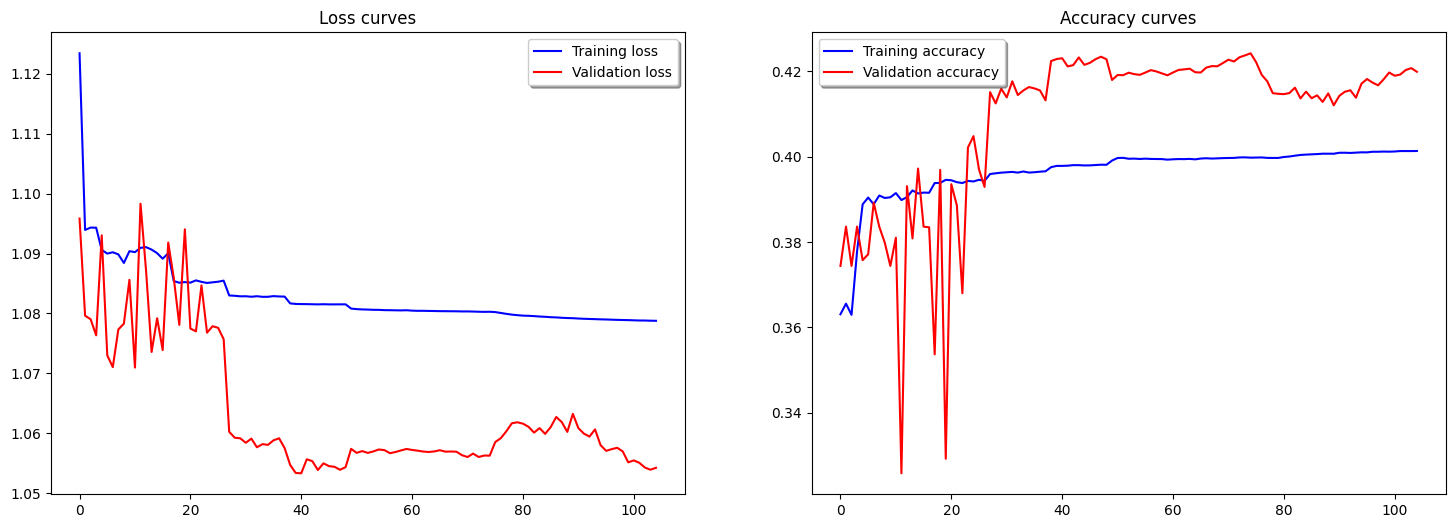

In [34]:
def train_model(model, train_ds, val_ds) -> Sequential:
    mcp_save = ModelCheckpoint("./model", save_best_only=True, monitor="val_accuracy", mode="max")
    lr_decay = ReduceLROnPlateau(monitor="loss", patience=8, verbose=0, factor=0.5, min_lr=1e-8)
    early_stop = EarlyStopping(
        monitor="val_accuracy",
        min_delta=0,
        patience=30 if SANITY_CHECK == False else 100,
        verbose=1,
        mode="auto",
        baseline=0,
        restore_best_weights=True,
    )
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=500)
    history = model.fit(
        train_ds,
        epochs=EPOCH,
        batch_size=BATCH,
        validation_data=val_ds,
        shuffle=True,
        verbose=1,
        max_queue_size=1000,
        workers=4,
        use_multiprocessing=True,
        callbacks=[lr_decay, early_stop, mcp_save, tensorboard_callback],
    )
    start = time()
    print("-" * 65)
    print(f"Training was completed in {time() - start:.2f} secs")
    print("-" * 65)
    return history

def plot_history(history):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    axs[0].plot(history.history["loss"], color="b", label="Training loss")
    axs[0].plot(history.history["val_loss"], color="r", label="Validation loss")
    axs[0].set_title("Loss curves")
    axs[0].legend(loc="best", shadow=True)
    axs[1].plot(history.history["accuracy"], color="b", label="Training accuracy")
    axs[1].plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
    axs[1].set_title("Accuracy curves")
    axs[1].legend(loc="best", shadow=True)
    plt.show()

history = train_model(model, train_ds, val_ds)
plot_history(history)

In [62]:
model = tf.keras.models.load_model(
    "./model"
)

In [63]:
def evaluate(model : Sequential, val_ds, test_ds):
    val_loss, val_acc = model.evaluate(val_ds, batch_size=BATCH, verbose=1)
    test_loss, test_acc = model.evaluate(test_ds, batch_size=BATCH, verbose=1)
    print("-" * 65)
    print(f"train accuracy = {round(val_acc * 100, 4)}%")
    print(f"test accuracy = {round(test_acc * 100, 4)}%")
    
evaluate(model, val_ds, test_ds)
predictions = model.predict(test_ds, batch_size=BATCH, verbose=1)
labels = np.concatenate([y for x, y in test_ds], axis=0)
input_data = np.concatenate([x for x, y in test_ds], axis=0)

1220/1220 [==============================] - 19s 15ms/step - loss: 1.0568 - accuracy: 0.4241
-----------------------------------------------------------------
train accuracy = 42.4198%
test accuracy = 42.4073%
1220/1220 [==============================] - 10s 7ms/step


In [64]:
labels_list = (list(map(lambda x: np.argmax(x), labels)))
predictions_list = (list(map(lambda x: np.argmax(x), predictions)))

confusion_matrix = tf.math.confusion_matrix(labels_list, predictions_list) 

tf.Tensor(
[[116907  26667  87428]
 [ 53073  45084  50147]
 [113656  28760 102890]], shape=(3, 3), dtype=int32)


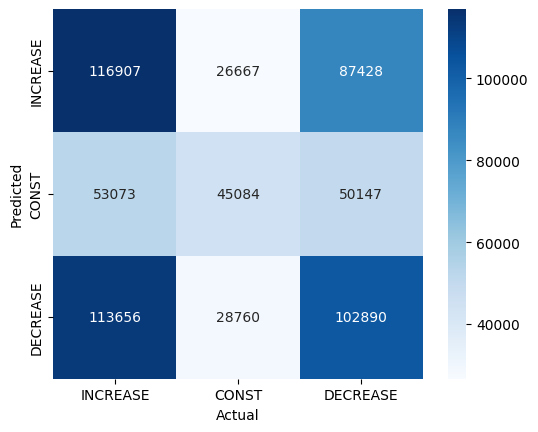

In [70]:
import seaborn
print(confusion_matrix)
ax = seaborn.heatmap(confusion_matrix, xticklabels=["INCREASE", "CONST", "DECREASE"], yticklabels=["INCREASE", "CONST", "DECREASE"], annot=True, square=True, cmap='Blues', fmt=".8g")
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show()